In [2]:
import pytorch_lightning as pl
from trainAgg import aggregationModule
from trainAgg import my_collate
import data_factory
import numpy as np
import torch
from config import cfg
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

In [3]:
#model = aggregationModule.load_from_checkpoint('/u/pop-d1/grad/cgar222/Projects/disaggregation/aggregation/lightning_logs/version_65/checkpoints/epoch=4-step=2504.ckpt')

In [4]:
this_dataset = data_factory.dataset_hennepin('train','/u/eag-d1/data/Hennepin/ver3/',
    '/u/eag-d1/data/Hennepin/ver3/hennepin_bbox.csv',
    '/u/pop-d1/grad/cgar222/Projects/disaggregation/dataset/hennepin_county_parcels/hennepin_county_parcels.shp')

torch.manual_seed(0)

train_size = int( np.floor( len(this_dataset) * (1-cfg.train.validation_split-cfg.train.test_split) ) )
val_size = int( np.floor( len(this_dataset) * cfg.train.validation_split) )
test_size = int( np.floor( len(this_dataset) * cfg.train.test_split ) )

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(this_dataset, [train_size, val_size, test_size])\


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=cfg.train.shuffle, collate_fn = my_collate,
                             num_workers=cfg.train.num_workers)

Reading GeoDataFrame...
Done
Generating list of useful chips


68        0102724310014
113       0102724340046
114       0102724340047
115       0102724340048
116       0102724340049
              ...      
437234    0411722310012
437235    0411722310013
437242    0411722320002
437243    0411722320003
437244    0411722320004
Name: PID, Length: 280345, dtype: object


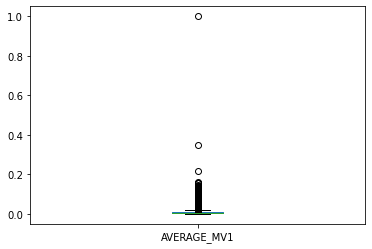

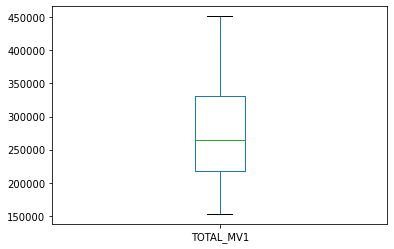

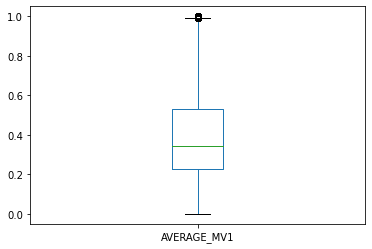

In [15]:
gdf = this_dataset.getgdf()

#print(gdf.keys().values,  sep='\n')
#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
plt.figure()
gdf['AVERAGE_MV1'].plot.box()
plt.savefig('/u/pop-d1/grad/cgar222/Projects/disaggregation/Plots/total_mv1.png')
values=  gdf['AVERAGE_MV1']
gdf = gdf[gdf['TOTAL_MV1'].between(gdf['TOTAL_MV1'].quantile(0.1), gdf['TOTAL_MV1'].quantile(0.9))]
plt.figure()
gdf['TOTAL_MV1'].plot.box()
values = values[values.between(values.quantile(0.1), values.quantile(0.9))]
values = (values - min( values )) / (max( values ) - min(values))
#values = values.where(values > 0)
#values = values.where(values < 10**6)
plt.figure()
values.plot.box()
plt.savefig('/u/pop-d1/grad/cgar222/Projects/disaggregation/Plots/total_mv1_fixed.png')
#print(gdf['TOTAL_MV1'].mean())
#plt.hist(gdf['SALE_PRICE'].values, bins=50)s

print(gdf['PID'])

In [6]:
import matplotlib as mpl
# lets get a batch and look at the cnn output

# https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t

with torch.no_grad(): 
    for batch in train_loader:
        image, parcel_masks, parcel_values = batch

        output = model.cnnOutput(image)
        plt.figure()
        # now we want to plot the images
        plt.imshow(  image[3].permute(1, 2, 0)  )
        plt.savefig('/u/pop-d1/grad/cgar222/Projects/disaggregation/Plots/image.png')
        plt.figure()
        
        # plot the outputs
        plt.imshow(  output[3].permute(1, 2, 0), cmap="YlGn")#, norm=mpl.colors.LogNorm()  )
        plt.colorbar()
        plt.savefig('/u/pop-d1/grad/cgar222/Projects/disaggregation/Plots/output.png')
        break   



ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/localdisk1/SCRATCH/cgar222/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/localdisk1/SCRATCH/cgar222/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/localdisk1/SCRATCH/cgar222/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/localdisk1/SCRATCH/cgar222/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataset.py", line 272, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/mounts/u-pop-d1/grad/cgar222/Projects/disaggregation/aggregation/data_factory.py", line 85, in __getitem__
    value = self.gdf.loc[ self.gdf['PID'] == pid ]['AVERAGE_MV1'].values.item()
ValueError: can only convert an array of size 1 to a Python scalar
